# MNIST classification(training)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install d2l

In [4]:
import torch.nn.utils.prune as prune
import torch , torchvision
from torch import nn
import numpy as np
from torchvision import datasets, transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

**using lenet for hessian visualization**

In [5]:
# using lenet for hessian visualization
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
lr = 1

config = {
    "save_path":"/content/drive/MyDrive/model",
    "early_stop": 5,
    'n_epochs': 20
}

epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10),nn.Sigmoid())


X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)


train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))


train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)

test_data = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size = len(test_data))

# Initialization
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)


print('training on', device)
net.to(device)

# def train(net, epoch, train_loader):
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    net.train()
    loss_record = []
    accuracy_record = []
    for train_data, train_label in train_loader:
        optimizer.zero_grad()
        X, y = train_data.to(device), train_label.to(device)
        # print(train_label)
        pred = net(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        # accuracy
        _,index = pred.data.cpu().topk(1, dim=1)
        accuracy_batch = np.sum((index.squeeze(dim=1) == train_label).numpy())
        accuracy_batch = accuracy_batch/len(train_label)
        accuracy_record.append(accuracy_batch)
    train_loss = sum(loss_record)/len(loss_record)
    train_accuracy = sum(accuracy_record)/len(accuracy_record)

    # validation
    net.eval()
    loss_record = []
    accuracy_record = []
    for val_data, val_label in test_loader:
        X, y = val_data.to(device), val_label.to(device)
        with torch.no_grad():
            pred = net(X)
            loss = criterion(pred, y)
        loss_record.append(loss.item())
        # accuracy
        _,index = pred.data.cpu().topk(1)
        accuracy_batch = np.sum((index.squeeze(dim=1) == val_label).numpy())
        accuracy_batch = accuracy_batch/len(val_label)
        accuracy_record.append(accuracy_batch)
    val_loss = sum(loss_record)/len(test_loader)
    val_accuracy = sum(accuracy_record)/len(accuracy_record)


    print(f'Epoch [{epoch+1}/{epochs}]: Train loss: {train_loss:.4f},Train accuracy: {train_accuracy:.4f}, Valid loss: {val_loss:.4f}, Valid accuracy: {val_accuracy:.4f}') 

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(net.state_dict(), config['save_path']) # Save your best model
        print('Saving model with loss {:.3f}...'.format(best_loss))
        early_stop_count = 0
    else: 
        early_stop_count += 1

    if early_stop_count >= config['early_stop']:
        print('\nModel is not improving, so we halt the training session.')
        break


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])
Sigmoid output shape: 	 torch.Size([1, 10])


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

training on cuda
Epoch [1/20]: Train loss: 1.7823,Train accuracy: 0.7174, Valid loss: 1.5771, Valid accuracy: 0.8719
Saving model with loss 1.577...
Epoch [2/20]: Train loss: 1.5539,Train accuracy: 0.8608, Valid loss: 1.5318, Valid accuracy: 0.8610
Saving model with loss 1.532...
Epoch [3/20]: Train loss: 1.5238,Train accuracy: 0.8775, Valid loss: 1.5122, Valid accuracy: 0.8983
Saving model with loss 1.512...
Epoch [4/20]: Train loss: 1.5095,Train accuracy: 0.9226, Valid loss: 1.5032, Valid accuracy: 0.9523
Saving model with loss 1.503...
Epoch [5/20]: Train loss: 1.4958,Train accuracy: 0.9641, Valid loss: 1.4871, Valid accuracy: 0.9717
Saving model with loss 1.487...
Epoch [6/20]: Train loss: 1.4859,Train accuracy: 0.9737, Valid loss: 1.4832, Valid accuracy: 0.9758
Saving model with loss 1.483...
Epoch [7/20]: Train loss: 1.4819,Train accuracy: 0.9775, Valid loss: 1.4814, Valid accuracy: 0.9772
Saving model w

In [6]:
len(test_data)

10000

In [7]:
model_load = torch.load('/content/drive/MyDrive/model')
net.load_state_dict(model_load)
net.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): Sigmoid()
)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

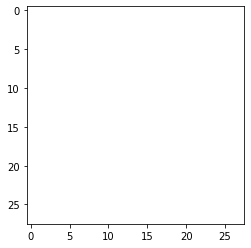

In [12]:
# Visualize 20 classification results and save as a gif
fig = plt.figure()
ax=fig.add_subplot()
ims = []
i = 1
# test_loader only one batch
for img, label in test_loader:
  img, label= img.to("cuda"), label.to('cuda')
  net.to('cuda')
  with torch.no_grad():
    pred = net(img)
    _, ind = pred.topk(1)
  for i, (index, true_label) in enumerate(zip(ind, label)):
    if i > 20:
      break
    image = ax.imshow(img[i][0].cpu().numpy())
    title_1 = ax.text(0,20,index.item(),color='r',fontsize=20) # 预测
    title_2 = ax.text(0,10,true_label.item(),color='g',fontsize=20) # 标签
    ims.append([image,title_1,title_2])
    i += 1
ani = animation.ArtistAnimation(fig, ims ,interval=1000, repeat_delay=10000)
ani.save("/content/drive/MyDrive/mnist.gif",writer='pillow')
# plt.show()

**MNIST classification end**

# Hessian matric calculate

In [18]:
# get parameters for prune
parameters_pruning = []
parameters_name = []
for name, param in net.named_parameters():
    if "weight" in name:
      print(name, param.shape)
      parameters_pruning.append(param)
      parameters_name.append(name)


## 把卷积层的参数和全连接层的参数分开？？求hessian的时候要不要分开？？？不分开的话，
## 那两种层的weight尺寸不同，遍历求每个元素的二阶导的时候，遍历的层数不一样怎么办？
## 为什么要用循环遍历而不用flatten,因为用flatten是做了一个复制，不能保证，比如loss对所有参数求导，不能实现对复制后并且变形了的向量的导数
## 不用循环的方式，统计所有参数的个数，对当前index映射回原来的pruning_parameterslist中对应的位置，获取一阶导数，再求二阶导数




0.weight torch.Size([6, 1, 5, 5])
3.weight torch.Size([16, 6, 5, 5])
7.weight torch.Size([120, 400])
9.weight torch.Size([84, 120])
11.weight torch.Size([10, 84])


**debuging**

In [21]:
num_list = np.array([x.numel() for x in parameters_pruning])
num_list

In [23]:
num = num_list.sum()
num

In [25]:
num_list_accumulate = np.cumsum(num_list)
num_list_accumulate

***!! calculate hessian !!***

In [27]:
# To calculate hessian ,we need a set of data first, here I use test data.
j = 0
for batch_idx, (data, target) in enumerate(test_loader):
    if j > 0:  # you can change 0 here to use more betchs of data
      break
    # ---------------------------------------------------------------calculate grad1(first order derivative)---------------------------------------------------------------
    data, target = data.to(device), target.to(device)
    output = net(data)
    loss = criterion(output, target)
    grad1 = torch.autograd.grad(loss,  parameters_pruning, create_graph=True)  # create_graph=True is key for second order derivative calculate in torch.autograd.grad
    num_shape = np.array([x.shape for x in grad1])  # shape for weight each layer
    num_list = np.array([x.numel() for x in grad1])  # numbers of parameters for each layer
    num_list_accumulate = np.cumsum(num_list)  # summation of numbers of parameters for layers befor each layer
    print(num_list_accumulate)
    num = num_list.sum()
    # ------------------------------------------------Write Hessian matix line by line, and save as a disk mapping-------------------------------------------------
    #If I use hessian = torch.tensor(np.zeros((num, num)), Memory overflow will occur, so I change to disk mapping.
    # First open a memmap file
    f = np.memmap('/content/drive/MyDrive/memmapped.dat', dtype='float32', mode='w+', shape=(num, num))
    # Then write Hessian matrix line by line
    # Remember to see shape of grad1, then you will understand why loop below should find layer_ind, index for a given i.
    for i in range(num):
        if i%1000 == 0:
          print(i)   # process records(to see how long this code can end run)
        grad_line = []
        layer_ind = np.searchsorted(num_list_accumulate, i, side='right')
        layer_shape = num_shape[layer_ind]

        if layer_ind > 0:
          ind_layer = i - num_list_accumulate[layer_ind - 1]
        else:
          ind_layer = i
        index = np.unravel_index(ind_layer, layer_shape)
        grad_element = grad1[layer_ind][index]
        grad2 = torch.autograd.grad(grad_element, parameters_pruning,retain_graph=True)
        for g2 in grad2:
          grad_line.append(g2.flatten().cpu().numpy())
        grad_line = np.concatenate(grad_line)
        f[i, :] = grad_line
    j += 1
f.flush()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


[  150  2550 50550 60630 61470]
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000


# Visualization Hessian

In [30]:
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns

**hessian 0-61470-100**

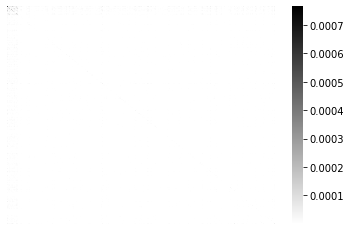

In [32]:
c = np.absolute(f[0:61470:100, 0:61470:100])
c = pd.DataFrame(c)
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="gray_r")
plt.savefig('/content/drive/MyDrive/hessian_0_61470_100', dpi=1080)

**hessian 3000-60000-100**

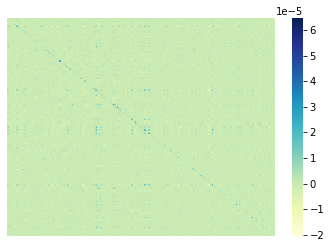

In [33]:
c = f[3000:60000:100, 3000:60000:100]
c = pd.DataFrame(c)
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian_3000_60000_100')

**hessian 50000-60000-4**

In [34]:
c = f[50000:60000:4, 50000:60000:4]
c = pd.DataFrame(c)

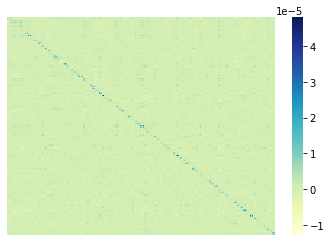

In [35]:
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian_50000_60000_4')

**hessian0-6000-2**

In [36]:
c = f[0:6000:2, 0:6000:2]
c = pd.DataFrame(c)

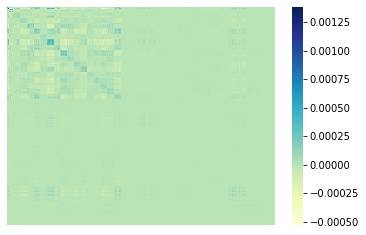

In [37]:
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian_6000_6000_2')

**hessian0-3000-2**

In [38]:
a = f[0:3000:2, 0:3000:2]

In [39]:
a = pd.DataFrame(a)

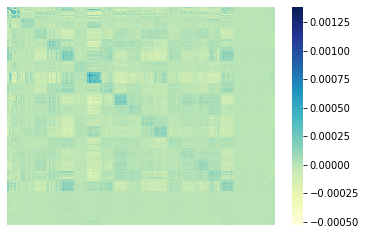

In [40]:
sns.heatmap(a,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian3000_3000_2')

**convolution part**

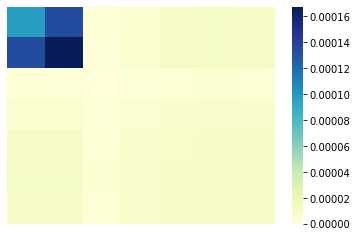

In [41]:
aa = f[2548:2555, 2548:2555]
aa = pd.DataFrame(aa)
sns.heatmap(aa,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian2548_2555_1')

**hessian 0-150-2**

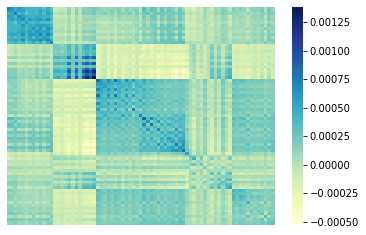

In [42]:
aa = f[0:150:2, 0:150:2]
aa = pd.DataFrame(aa)
sns.heatmap(aa,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian150_150_2')

**hessian 0-150-1**

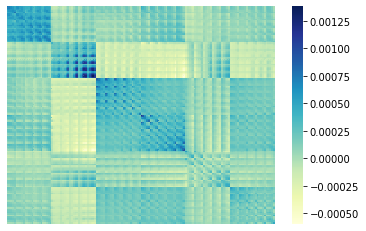

In [43]:
aa = f[0:150, 0:150]
aa = pd.DataFrame(aa)
sns.heatmap(aa,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian150_150_1')

**hessian 0-50-1**

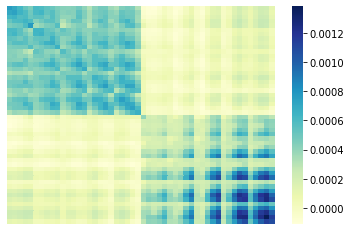

In [44]:
aa = f[0:50, 0:50]
aa = pd.DataFrame(aa)
sns.heatmap(aa,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian50_50_1')

**hessian 0-25-1**

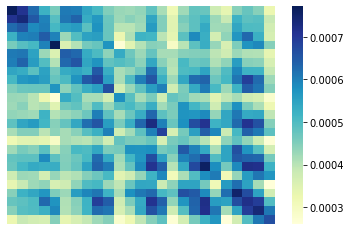

In [45]:
aa = f[0:25, 0:25]
aa = pd.DataFrame(aa)
sns.heatmap(aa,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.savefig('/content/drive/MyDrive/hessian25_25_1')

# Parameters value visualization

In [46]:
parameters_all = np.concatenate([param.detach().cpu().flatten().numpy() for param in parameters_pruning])

In [47]:
parameters_all.shape

(61470,)

**Parameters visulization（the first 5*5 convolutional kernel）**

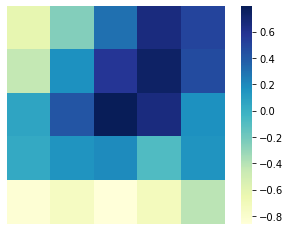

In [48]:
aa = parameters_all[0:25].reshape(5,5)
aa = pd.DataFrame(aa)
sns.heatmap(aa, xticklabels=False, yticklabels=False, cmap="YlGnBu", square=True).invert_yaxis
plt.savefig('/content/drive/MyDrive/conv_visual')

(615, 1)
(615, 615)


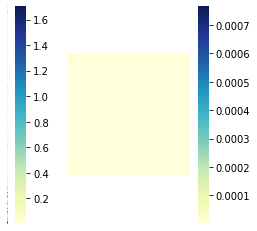

In [49]:
fig, axes = plt.subplots(1,2)
parameters = pd.DataFrame(np.absolute(parameters_all[0:61470:100]))
print(parameters.shape)
sns.heatmap(parameters, xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[0], square=True)

c = np.absolute(f[0:61470:100, 0:61470:100])
c = pd.DataFrame(c)
print(c.shape)
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[1], square=True)
plt.savefig('/content/drive/MyDrive/hessian_compare', dpi=1080)

(50, 1)
(50, 50)


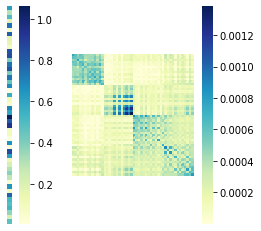

In [50]:
fig, axes = plt.subplots(1,2)
parameters = pd.DataFrame(np.absolute(parameters_all[0:100:2]))
print(parameters.shape)
sns.heatmap(parameters, xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[0], square=True)

c = np.absolute(f[0:100:2, 0:100:2])
c = pd.DataFrame(c)
print(c.shape)
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[1], square=True)
plt.savefig('/content/drive/MyDrive/hessian_compare_100', dpi=1080)

(25, 1)
(25, 25)


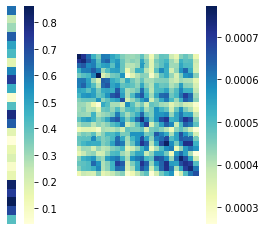

In [51]:
fig, axes = plt.subplots(1,2)
parameters = pd.DataFrame(np.absolute(parameters_all[0:25]))
print(parameters.shape)
sns.heatmap(parameters, xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[0], square=True)

c = np.absolute(f[0:25, 0:25])
c = pd.DataFrame(c)
print(c.shape)
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[1], square=True)
plt.savefig('/content/drive/MyDrive/hessian_compare_50_2', dpi=1080)

(25, 1)
(25, 1)


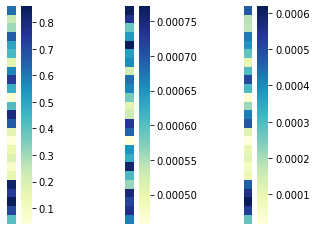

In [56]:
fig, axes = plt.subplots(1,3)
parameter = np.absolute(parameters_all[0:25])
parameters = pd.DataFrame(parameter)
print(parameters.shape)
sns.heatmap(parameters, xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[0], square=True)

c_n = np.diagonal(np.absolute(f[0:25, 0:25]))
c = pd.DataFrame(c_n)
print(c.shape)
sns.heatmap(c,xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[1], square=True)

d = parameter * c_n
d = pd.DataFrame(d)
sns.heatmap(d,xticklabels=False, yticklabels=False, cmap="YlGnBu", ax=axes[2], square=True)
plt.savefig('/content/drive/MyDrive/hessian_compare_50_2', dpi=1080)


**代码问题：1.求二阶导准确吗，待测试 2.用了磁盘映射，因为矩阵太大了3.为了求二阶导不能拆了自动求导树，不能flatten()之后再求二阶导，遍历的问题，尝试了递归，但是没法写到磁盘对应的行（不知道是哪一行），也没用多层循环，最后选择一层循环，算是虚拟的flatten()????**

**问题：1.二阶偏导的值和权值本身的大小有关系吗。2.权值的可视化，做个对比。3.第一层的权值和最后一层的权值是怎么扯上关系的（为什么不是零）。4.泰勒展开的时候，如果只有一个权值改变了，根本不需要假设偏导是零？？**

**待做问题：1.试试基于权值剪枝(用pytorch带的prune接口实现）的mask作用之后的hesiian矩阵，有意义吗？？？回答：前提是Hessian比幅值要好**

# 还想试试：想可视化这个模型对应的函数（但是自变量维度太高了）